In [4247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from copy import deepcopy as dc
lags = 12

In [4248]:
def refresh_data(keep_short_data = False):
    X = pd.read_excel("X.xlsx")
    y = pd.read_excel("PPI.xlsx")
    y.set_index("指标名称",inplace=True)
    y.index = pd.to_datetime(y.index,format= "%Y%m%d")
   
    X.set_index("指标名称",inplace=True)
    X.index = pd.to_datetime(X.index,format= "%Y%m%d")
    X = X.fillna(method="bfill")
    X = X.resample("m").mean()
    if  not keep_short_data:
        X = X[(X.index <="2024-03-31")& (X.index>="2016-01-01")]
        X.drop(columns=['纯碱','纸浆', '尿素', '乙二醇'], inplace=True)
        y = y[y.index >="2016-01-01"]
    else: 
        X = X[(X.index <="2024-03-31")& (X.index>="2019-12-06")]
        y = y[y.index >="2019-12-06"]
    X = X.dropna()
    X_original = dc(X)
    return X,y,X_original

In [4249]:
#选取2016年1月1日至今为止约8年的数据。原因：许多品种是2015年上市的。
#去除纯碱、纸浆、尿素、乙二醇，因为这几个品种在2016-2018/19之间无数据
X,y,X_original = refresh_data(keep_short_data = False)
# X.to_excel("X_new.xlsx")
# y.to_excel("y_new.xlsx")
X.head()

/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/768718636.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/768718636.py:10: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = X.resample("m").mean()


,铜,原油,焦炭,焦煤,铝,螺纹钢,热轧卷板,锡,铁矿石,镍,锌,铅,天然橡胶,硅铁,石油沥青,燃料油,甲醇,棕榈油
指标名称,,,,,,,,,,,,,,,,,,
2016-01-31,35360.500000,31.698000,633.675000,545.300000,10833.750000,1797.000000,1915.200000,94781.000000,314.700000,68702.000000,12825.250000,12941.750000,10104.000000,3945.000000,1746.400000,2542.500000,1741.800000,4692.100000
2016-02-29,35987.142857,30.759048,662.309524,573.738095,10868.095238,1874.761905,1983.380952,100795.238095,345.523810,68090.476190,13797.380952,13716.428571,10369.761905,4203.238095,1683.333333,2544.666667,1801.761905,4897.333333
2016-03-31,37553.913043,38.119565,748.695652,614.717391,11396.304348,2088.608696,2274.869565,109207.391304,408.043478,68916.521739,14233.478261,13623.478261,11329.347826,4732.782609,1821.826087,2260.086957,1909.000000,5249.478261
2016-04-30,37032.380952,41.247619,944.738095,715.642857,12130.000000,2401.190476,2643.809524,108870.952381,421.500000,69826.666667,14715.476190,13248.809524,12419.047619,4398.952381,1936.857143,2426.761905,1951.380952,5581.428571
2016-05-31,36016.818182,46.966364,920.045455,696.136364,12387.045455,2124.090909,2301.681818,108525.454545,380.159091,69485.454545,14951.363636,12915.000000,11369.318182,4066.636364,1928.272727,2433.227273,1913.500000,5281.636364


In [4250]:
def run_lasso(X,y,alpha = 0.2, need_var_name = False, need_model = False, need_data = False, need_train = False):
    # 数据预处理，包括标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 将数据集拆分为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    # 创建Lasso回归模型
    lasso = Lasso(alpha=0.2)  # alpha为正则化项的系数
    # 拟合模型
    lasso.fit(X_train, y_train)
    print("Coefficients:", lasso.coef_)
    # 找出系数不为零的变量
    non_zero_coefficients = [X.columns[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
    print("Non-zero Coefficients Variables:", non_zero_coefficients)
    y_pred = lasso.predict(X_test)
    # 评估模型性能
    from sklearn.metrics import mean_squared_error, r2_score
    print("Mean squared error:", mean_squared_error(y_test, y_pred))
    print("R-squared:", r2_score(y_test, y_pred))
    if  need_var_name and need_data and need_model:
        return non_zero_coefficients, X_test, y_test, y_pred,lasso
    elif need_var_name and need_data:
        return non_zero_coefficients, X_test, y_test, y_pred
    elif need_data and need_model:
        return X_test, y_test, y_pred, lasso
    elif need_var_name:
        return non_zero_coefficients
    elif need_data:
        return  X_test, y_test, y_pred
    if need_train:
        return X_train,y_train

In [4251]:
def plot_corr_heatmap(X):
    matplotlib.rcParams['font.family'] ="Arial Unicode MS"
    corr_matrix = X.corr()
    plt.figure(figsize=(10, 8))  # 设置图形的大小
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix')
    plt.show()

In [4252]:
from copy import deepcopy as dc
def add_lags(data, number_of_lags):
    """
    为数据框中的每个变量添加指定数量的滞后项。
    :param data: 原始数据框
    :param number_of_lags: 需要添加的滞后项数量
    :return: 增加滞后项后的数据框
    """
    df = dc(data)
    for column in data.columns:
        for lag in range(1, number_of_lags + 1):
            df[f'{column}lag{lag}'] = data[column].shift(lag)
    return df

In [4253]:
def run_ols(X,y):
    data = pd.concat([X,y],axis = 1)
    reg_rule = str(data.columns[-1]) + "~"
    for i in range(0,len(data.columns) -1):
        if i != len(data.columns)-2:
            reg_rule += str(data.columns[i]) + "+ "
        else:
            reg_rule += str(data.columns[i])
    model = smf.ols(reg_rule, data=data).fit()
    print(model.summary())
    return model

In [4254]:
def predict_April_PPI(model, var_list):
    X = pd.read_excel("X.xlsx")
    X.set_index("指标名称",inplace=True)
    X.index = pd.to_datetime(X.index,format= "%Y%m%d")
    X = X.fillna(method="bfill")
    X = X.resample("m").mean()
    X = add_lags(X,lags)
    X = X[X.index=="2024-04-30"]
    data = X.loc[:,var_list]
    prediction = model.predict(data)
    print("Estimated PPI for April is " + str(prediction[0]))

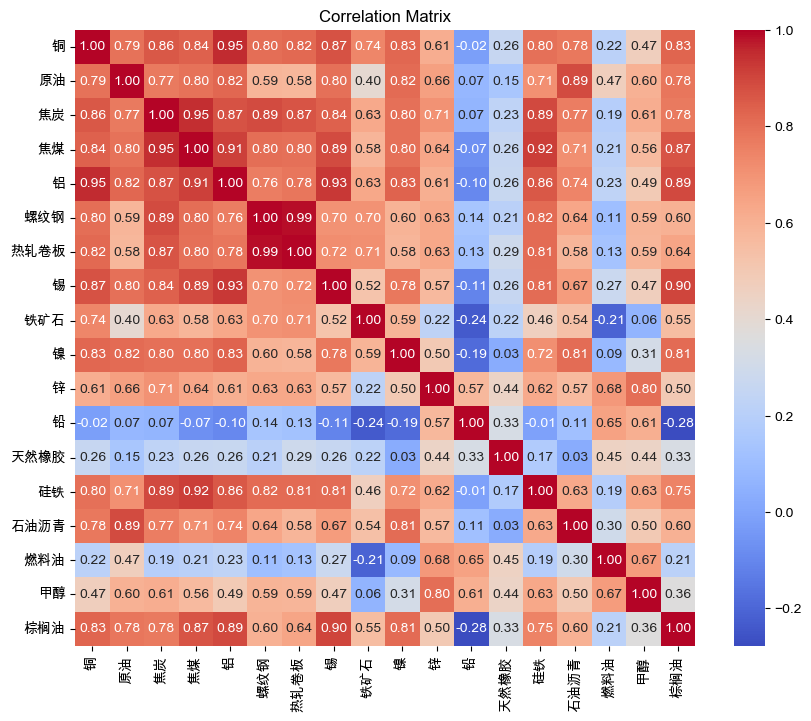

In [4255]:
plot_corr_heatmap(X)

In [4256]:
new_vars= run_lasso(X,y,need_var_name=True)

Coefficients: [-0.         -0.          0.         -0.         -0.          0.
  0.06076828 -0.36507025 -0.          0.          2.29816481  0.16634329
 -2.37755072  0.         -0.         -0.          1.87966517 -0.        ]
Non-zero Coefficients Variables: ['热轧卷板', '锡', '锌', '铅', '天然橡胶', '甲醇']
Mean squared error: 7.08703231087077
R-squared: 0.6643494684918134


In [4257]:
X = X.loc[:,new_vars]
run_lasso(X,y)
run_ols(X,y)

Coefficients: [ 0.06082979 -0.36517509  2.29817436  0.16625446 -2.37757953  1.87973662]
Non-zero Coefficients Variables: ['热轧卷板', '锡', '锌', '铅', '天然橡胶', '甲醇']
Mean squared error: 7.086937955812718
R-squared: 0.664353937262943
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     23.13
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.78e-16
Time:                        11:00:51   Log-Likelihood:                -244.94
No. Observations:                  99   AIC:      

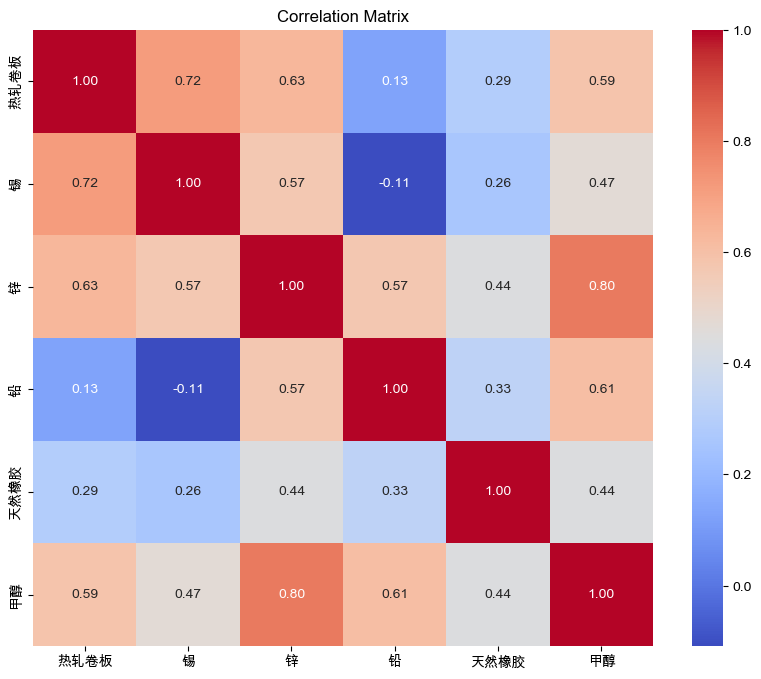

In [4258]:
plot_corr_heatmap(X)

In [4259]:
#We need to take away collinearary features(above0.8)
X = X.loc[:, ['热轧卷板','天然橡胶', '甲醇']]
run_ols(X,y)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     46.88
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.11e-18
Time:                        11:00:51   Log-Likelihood:                -245.50
No. Observations:                  99   AIC:                             499.0
Df Residuals:                      95   BIC:                             509.4
Df Model:                           3                                         
Covariance Type:            nonrobust  

In [4260]:
X_lagged = add_lags(X_original, lags)
X_lagged = pd.concat([X_lagged,y], axis = 1)
X_lagged = X_lagged.dropna()
y = pd.DataFrame(X_lagged.iloc[:,-1])
X_lagged = X_lagged.iloc[:,:-1]
print(y.columns)
print(X_lagged.columns)

Index(['PPI当月同比'], dtype='object')
Index(['铜', '原油', '焦炭', '焦煤', '铝', '螺纹钢', '热轧卷板', '锡', '铁矿石', '镍',
       ...
       '棕榈油lag3', '棕榈油lag4', '棕榈油lag5', '棕榈油lag6', '棕榈油lag7', '棕榈油lag8',
       '棕榈油lag9', '棕榈油lag10', '棕榈油lag11', '棕榈油lag12'],
      dtype='object', length=234)


/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

In [4261]:
new_vars= run_lasso(X_lagged,y, need_var_name=True)

Coefficients: [-0.          0.          0.          0.          0.          0.
  0.          0.72494792 -0.         -0.          0.          0.
  0.          0.05230516 -0.          0.          0.1827011   0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.15057212
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.48477641
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.        

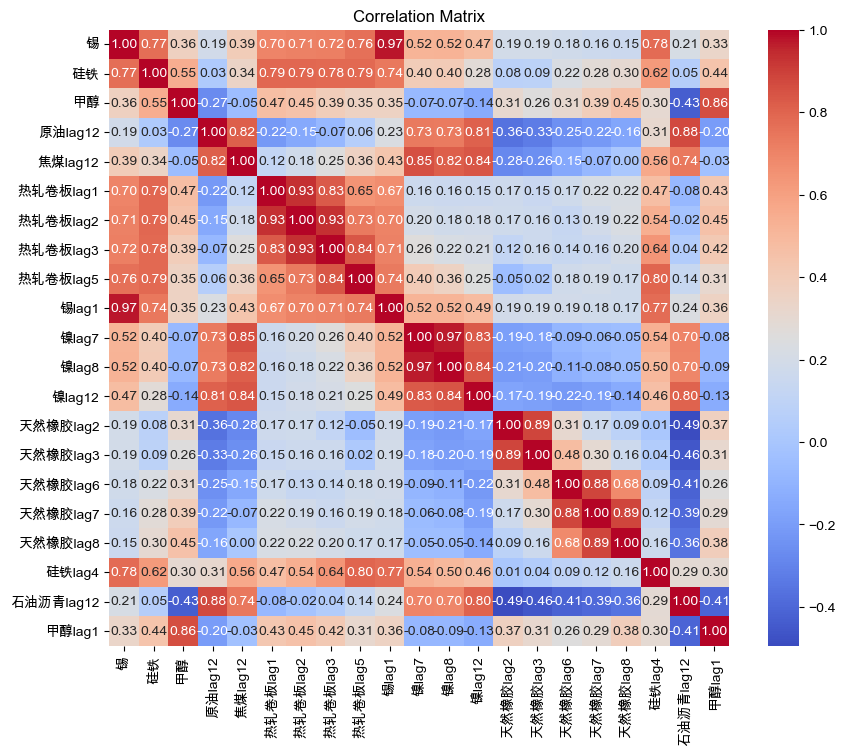

In [4262]:
X_lagged = X_lagged.loc[:, new_vars]
plot_corr_heatmap(X_lagged)

In [4263]:
new_vars

['锡',
 '硅铁',
 '甲醇',
 '原油lag12',
 '焦煤lag12',
 '热轧卷板lag1',
 '热轧卷板lag2',
 '热轧卷板lag3',
 '热轧卷板lag5',
 '锡lag1',
 '镍lag7',
 '镍lag8',
 '镍lag12',
 '天然橡胶lag2',
 '天然橡胶lag3',
 '天然橡胶lag6',
 '天然橡胶lag7',
 '天然橡胶lag8',
 '硅铁lag4',
 '石油沥青lag12',
 '甲醇lag1']

In [4264]:
run_ols(X_lagged,y)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     152.9
Date:                Mon, 13 May 2024   Prob (F-statistic):           3.18e-47
Time:                        11:00:52   Log-Likelihood:                -84.537
No. Observations:                  87   AIC:                             213.1
Df Residuals:                      65   BIC:                             267.3
Df Model:                          21                                         
Covariance Type:            nonrobust  

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     390.5
Date:                Mon, 13 May 2024   Prob (F-statistic):           8.05e-49
Time:                        11:00:52   Log-Likelihood:                -136.94
No. Observations:                  87   AIC:                             281.9
Df Residuals:                      83   BIC:                             291.7
Df Model:                           3                                         
Covariance Type:            nonrobust  

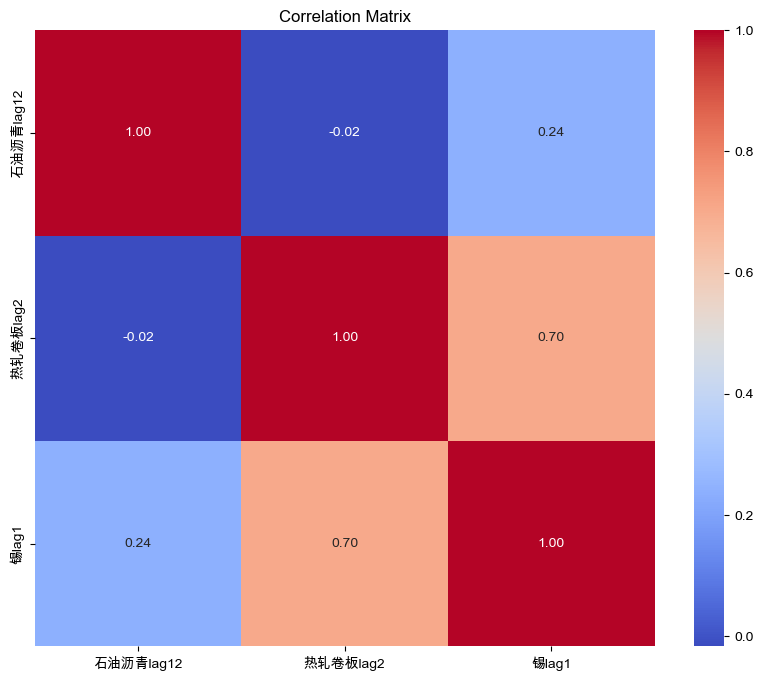

Coefficients: [-3.51096731  1.57768612  1.23612808]
Non-zero Coefficients Variables: ['石油沥青lag12', '热轧卷板lag2', '锡lag1']
Mean squared error: 0.9214524175059733
R-squared: 0.9434542138135025
Coefficients: [-3.51096731  1.57768612  1.23612808]
Non-zero Coefficients Variables: ['石油沥青lag12', '热轧卷板lag2', '锡lag1']
Mean squared error: 0.9214524175059733
R-squared: 0.9434542138135025


In [4265]:
#second round delete features, corr>=0.5
X_lagged = X_lagged.loc[:,[
'石油沥青lag12',
'热轧卷板lag2',
'锡lag1'
]]
model = run_ols(X_lagged,y)
plot_corr_heatmap(X_lagged)
X_test,y_test,y_pred= run_lasso(X_lagged,y,need_data=True)
X_train,y_train = run_lasso(X_lagged,y, need_train=True )

In [4266]:
predict_April_PPI(model, ['石油沥青lag12','热轧卷板lag2','锡lag1'])

Estimated PPI for April is -2.062939340032436


/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3847335220.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3847335220.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = X.resample("m").mean()
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragme

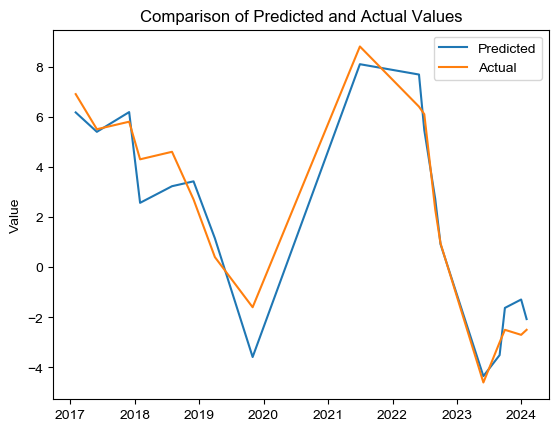

In [4267]:

def plot_result(y_test:pd.DataFrame,y_pred:np.array): 
    result = pd.concat([y_test,pd.DataFrame(y_pred,index=y_test.index, columns = ["predicted_PPI"])],axis = 1)
    result.sort_index(inplace=True)
    plt.plot(result.index, result.iloc[:,1], label='Predicted')
    plt.plot(result.index, result.iloc[:,0], label='Actual')
    plt.title('Comparison of Predicted and Actual Values')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
plot_result(y_test,y_pred)

In [4268]:
#现在构思一个新模型，基于纯碱(SA），纸浆(SP），尿素(UR)，乙二醇(EG)这几个新品种存在的区间
#这几个中上市最晚的是纯碱，以它为准
X,y, X_original=refresh_data(keep_short_data=True)

/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/768718636.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/768718636.py:10: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = X.resample("m").mean()


In [4269]:
new_vars= run_lasso(X,y,need_var_name=True)

Coefficients: [-0.          0.3205803   0.          1.22424642 -0.          0.
  0.          0.         -1.40705919 -0.          1.76339348 -0.97153002
 -0.07565493 -0.          0.         -0.         -0.          1.18877964
  0.          0.82152638  0.          0.        ]
Non-zero Coefficients Variables: ['原油', '焦煤', '铁矿石', '锌', '铅', '天然橡胶', '棕榈油', '纸浆']
Mean squared error: 2.730743369926965
R-squared: 0.7590426843816268


In [4270]:
X = X.loc[:,new_vars]
run_lasso(X,y)

Coefficients: [ 0.32083755  1.22442189 -1.40694804  1.76407616 -0.97165823 -0.07556085
  1.18802742  0.82118711]
Non-zero Coefficients Variables: ['原油', '焦煤', '铁矿石', '锌', '铅', '天然橡胶', '棕榈油', '纸浆']
Mean squared error: 2.730809609882121
R-squared: 0.7590368394523827


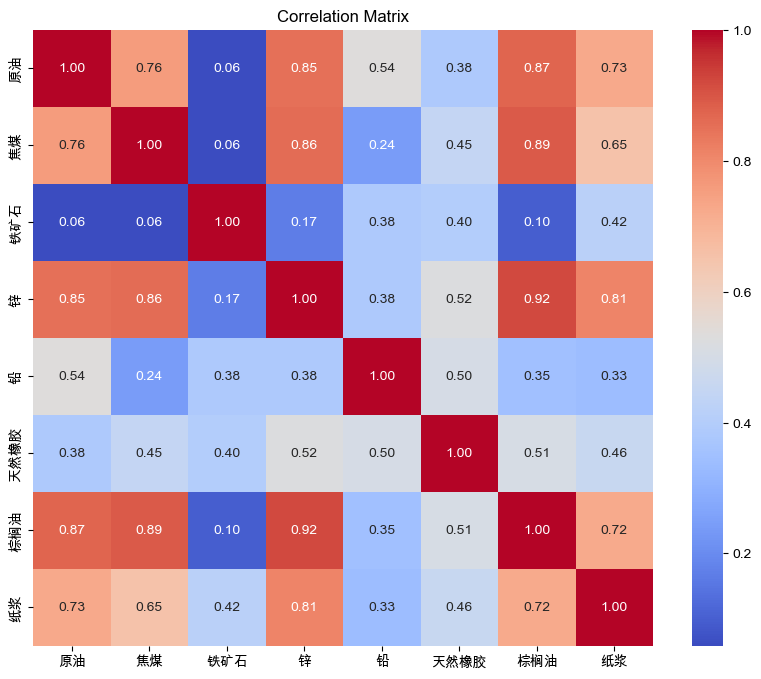

Index(['原油', '焦煤', '铁矿石', '锌', '铅', '天然橡胶', '棕榈油', '纸浆'], dtype='object')

In [4271]:
plot_corr_heatmap(X)
X.columns
#改善多重共线性时会把新加进去的变量筛掉，所以如果只用原品种没有数据加工，带不带新品种没区别

In [4272]:
X_lagged = add_lags(X_original, lags)
X_lagged = pd.concat([X_lagged,y], axis = 1)
X_lagged = X_lagged.dropna()
y = pd.DataFrame(X_lagged.iloc[:,-1])
X_lagged = X_lagged.iloc[:,:-1]
print(y.columns)
print(X_lagged.columns)

Index(['PPI当月同比'], dtype='object')
Index(['铜', '原油', '焦炭', '焦煤', '铝', '螺纹钢', '热轧卷板', '锡', '铁矿石', '镍',
       ...
       '乙二醇lag3', '乙二醇lag4', '乙二醇lag5', '乙二醇lag6', '乙二醇lag7', '乙二醇lag8',
       '乙二醇lag9', '乙二醇lag10', '乙二醇lag11', '乙二醇lag12'],
      dtype='object', length=286)


/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

In [4273]:
new_vars = run_lasso(X_lagged,y,need_var_name=True)

Coefficients: [ 0.          0.          0.02117782  0.          0.          0.29969758
  0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.         -0.          0.30491063  0.
  0.          0.          0.          0.12759184  0.          0.
  0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.99111397  0.
  0.          0.1496769   0.          0.          0.          0.
  0

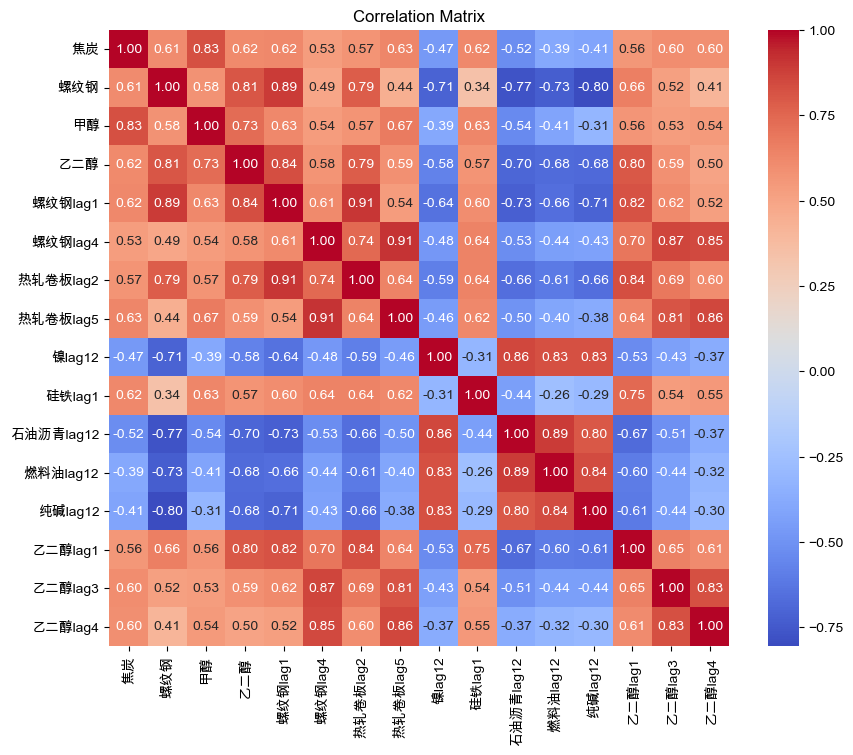

In [4274]:
X_lagged = X_lagged.loc[:, new_vars]
plot_corr_heatmap(X_lagged)

In [4275]:
new_vars

['焦炭',
 '螺纹钢',
 '甲醇',
 '乙二醇',
 '螺纹钢lag1',
 '螺纹钢lag4',
 '热轧卷板lag2',
 '热轧卷板lag5',
 '镍lag12',
 '硅铁lag1',
 '石油沥青lag12',
 '燃料油lag12',
 '纯碱lag12',
 '乙二醇lag1',
 '乙二醇lag3',
 '乙二醇lag4']

In [4276]:
run_ols(X_lagged,y)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     530.5
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.15e-25
Time:                        11:00:53   Log-Likelihood:                -7.3783
No. Observations:                  40   AIC:                             48.76
Df Residuals:                      23   BIC:                             77.47
Df Model:                          16                                         
Covariance Type:            nonrobust  

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                PPI当月同比   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     319.0
Date:                Mon, 13 May 2024   Prob (F-statistic):           5.62e-26
Time:                        11:00:53   Log-Likelihood:                -59.309
No. Observations:                  40   AIC:                             126.6
Df Residuals:                      36   BIC:                             133.4
Df Model:                           3                                         
Covariance Type:            nonrobust  

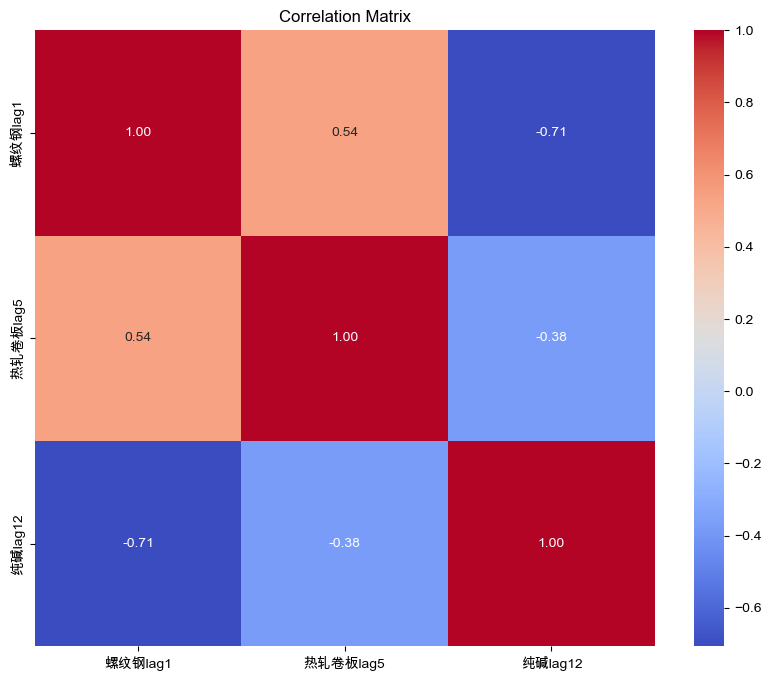

In [4277]:
#second round delete features, corr>=0.5
X_lagged = X_lagged.loc[:,[
 '螺纹钢lag1',
 '热轧卷板lag5', 
 '纯碱lag12'
 ]]
model = run_ols(X_lagged,y)
plot_corr_heatmap(X_lagged)

In [4278]:
predict_April_PPI(model, ['螺纹钢lag1','热轧卷板lag5', '纯碱lag12'])

Estimated PPI for April is -2.44341507028148


/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3847335220.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="bfill")
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3847335220.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = X.resample("m").mean()
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}lag{lag}'] = data[column].shift(lag)
/var/folders/2x/tkbc5q7n31xdfzmxs8mpjhd00000gn/T/ipykernel_74393/3385039114.py:12: PerformanceWarning: DataFrame is highly fragme

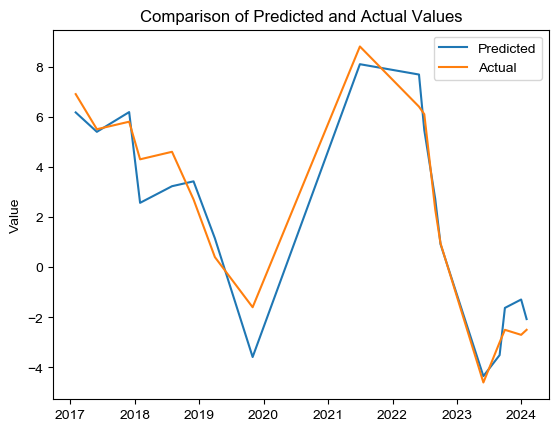

In [4279]:
plot_result(y_test, y_pred)